In [1]:
import xarray as xr
import rioxarray
import numpy as np
import os
import re
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
from src.hls_funcs import fetch
from src.hls_funcs.masks import mask_hls, shp2mask
from src.hls_funcs.indices import ndvi_func

In [2]:
# set up a local cluster
from dask.distributed import LocalCluster, Client
import dask

# setup environment
aws=False
fetch.setup_env(aws=aws)

# create the cluster
cluster = LocalCluster(n_workers=6, threads_per_worker=2)

# create the client from the cluster
client = Client(cluster)

# display the client and link for dashboard
display(client)

2023-02-13 15:18:01,902 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-3z02tbhr', purging
2023-02-13 15:18:01,903 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-09rb4qsr', purging
2023-02-13 15:18:01,903 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-s57b9l05', purging
2023-02-13 15:18:01,903 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-exjqx9b5', purging
2023-02-13 15:18:01,903 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-yry8ni23', purging
2023-02-13 15:18:01,904 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-aieydpe4', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 12,Total memory: 11.85 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39671,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 11.85 GiB
Comm: tcp://127.0.0.1:43779,Total threads: 2
Dashboard: http://127.0.0.1:34931/status,Memory: 1.98 GiB
Nanny: tcp://127.0.0.1:45111,


In [3]:
# load csv of ground data
df_aoi_txt = pd.read_csv('../data/bm_extract/TB_all_bm.csv', parse_dates=[1])
# drop NEX transects in ungulate exclosures
df_aoi_txt = df_aoi_txt[~df_aoi_txt['ID'].str.contains('ungulate ex')]

# convert to GeoDataFrame using coordinates
gdf_aoi = gpd.GeoDataFrame(
    df_aoi_txt, geometry=gpd.points_from_xy(df_aoi_txt['gps_E'], df_aoi_txt['gps_N']))
# set the coordinate system
gdf_aoi = gdf_aoi.set_crs(epsg=32613)
# buffer the points to extract surrounding pixels later
gdf_aoi.geometry = gdf_aoi.buffer(150)

In [4]:
# preview the geodataframe
gdf_aoi

,ID,Date,Project,gps_E,gps_N,Method,bm_gm2,geometry
0,1937-l-in,2015-07-15,FIRE,476873.487448,4.791805e+06,clip,152.956500,"POLYGON ((477023.487 4791805.442, 477022.765 4..."
1,1974-l-in,2015-07-20,FIRE,485662.435950,4.786828e+06,clip,151.540000,"POLYGON ((485812.436 4786828.498, 485811.714 4..."
2,1974-l-out,2015-07-20,FIRE,485729.525400,4.787084e+06,clip,99.499500,"POLYGON ((485879.525 4787083.960, 485878.803 4..."
3,1nw01,2017-08-15,PDOG,494356.295000,4.817504e+06,clip,58.320000,"POLYGON ((494506.295 4817504.255, 494505.573 4..."
4,2duchardtE24,2017-08-15,PDOG,493635.375000,4.818165e+06,clip,58.660000,"POLYGON ((493785.375 4818164.660, 493784.653 4..."
...,...,...,...,...,...,...,...,...
3142,wildcat-prairie dog-out,2020-07-13,NEX,517132.712854,4.836233e+06,clip,34.293333,"POLYGON ((517282.713 4836232.742, 517281.991 4..."
3143,wildcat-prairie dog-out,2020-07-13,NEX,517132.712854,4.836233e+06,vor,95.202967,"POLYGON ((517282.713 4836232.742, 517281.991 4..."
3144,wildcat-prairie dog-out,2020-08-06,NEX,517132.712854,4.836233e+06,clip,157.232000,"POLYGON ((517282.713 4836232.742, 517281.991 4..."
3145,wildcat-prairie dog-out,2021-07-12,NEX,517132.712854,4.836233e+06,clip,84.700000,"POLYGON ((517282.713 4836232.742, 517281.991 4..."


In [5]:
# look at the unique projects
gdf_aoi.groupby('Project').apply(lambda x: x['Date'].dt.year.unique())

Project
BIRD                [2015, 2016, 2017, 2018, 2019]
FIRE                                        [2015]
NEX     [2015, 2016, 2017, 2018, 2019, 2020, 2021]
PDOG                      [2017, 2021, 2018, 2019]
WTGN                            [2019, 2020, 2021]
dtype: object

In [6]:
# Get just the priarie dog project data for one year
gdf_pdog_2019 = gdf_aoi[(gdf_aoi['Project'] == 'NEX') & (gdf_aoi['Date'].dt.year == 2019)].copy()
#gdf_pdog_2019 = gdf_pdog_2019[gdf_pdog_2019['ID'] == 'lake creek-control-out']

# convert timestamp to date for simplicity later
# convert the 'Date' column to date instead of timestamp
gdf_pdog_2019['Date'] = gdf_pdog_2019['Date'].dt.date

# preview
gdf_pdog_2019.head(5)

,ID,Date,Project,gps_E,gps_N,Method,bm_gm2,geometry
2501,lake creek-control-livestock ex,2019-07-01,NEX,490771.571731,4.797154e+06,clip,180.666667,"POLYGON ((490921.572 4797154.182, 490920.849 4..."
2502,lake creek-control-livestock ex,2019-07-01,NEX,490771.571731,4.797154e+06,vor,157.441317,"POLYGON ((490921.572 4797154.182, 490920.849 4..."
2503,lake creek-control-livestock ex,2019-07-31,NEX,490771.571731,4.797154e+06,clip,119.540000,"POLYGON ((490921.572 4797154.182, 490920.849 4..."
2519,lake creek-control-out,2019-07-01,NEX,490853.172237,4.797254e+06,clip,145.166667,"POLYGON ((491003.172 4797253.913, 491002.450 4..."
2520,lake creek-control-out,2019-07-01,NEX,490853.172237,4.797254e+06,vor,127.647834,"POLYGON ((491003.172 4797253.913, 491002.450 4..."


In [7]:
# subset to only the clip data
gdf_pdog_2019 = gdf_pdog_2019[gdf_pdog_2019['Method'] == 'clip'].copy()

# subset only to the data outside exclosures
gdf_pdog_2019 = gdf_pdog_2019[gdf_pdog_2019['ID'].str.contains('out')].copy()

<AxesSubplot:>

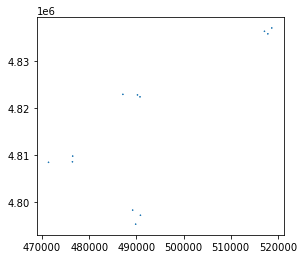

In [8]:
gdf_pdog_2019.plot()

<AxesSubplot:>

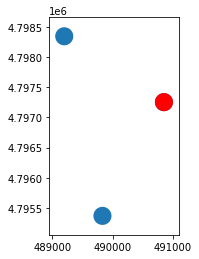

In [9]:
# create a single plot from the first row of project data
# NOTE: double brackets [[]] returns a geodataframe. Single brackets returns a geoseries. You need a geodataframe for plotting
gdf_plot = gdf_pdog_2019.iloc[[0]]

# get only the data for the date that matches the first row
gdf_pdog_2019 = gdf_pdog_2019[gdf_pdog_2019['Date'] == gdf_plot.iloc[0].Date].copy()

# preview the plot
ax = gdf_pdog_2019.plot()
gdf_plot.plot(color='red', ax=ax)

<AxesSubplot:>

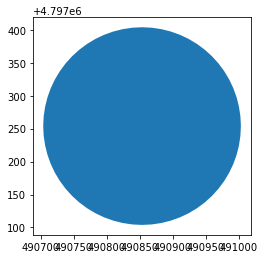

In [10]:
# map the individual plot
gdf_plot.plot()

In [11]:
# get the data range for the fetch as a dictionary
start_date = gdf_plot.iloc[0].Date - timedelta(days=15)
end_date = gdf_plot.iloc[0].Date + timedelta(days=15)
data_dict = {'date_range': [str(start_date), 
                            str(end_date)]}

#preview
data_dict

{'date_range': ['2019-06-16', '2019-07-16']}

In [12]:
# set the bounding box for fetching data
bbox_plot = np.array(gdf_plot.iloc[0].geometry.bounds) # just the plot
bbox_data = np.array(gdf_pdog_2019.total_bounds) # the entire subset dataset 

# preview
bbox_data

array([ 489048.36321275, 4795216.16436327,  491003.17223681,
       4798497.07029462])

In [13]:
# fetch the data for the entire project PDOG, but for the date range around the single plot
hls_ds = fetch.get_hls(hls_data=data_dict,
                       bbox=bbox_data, 
                       stack_chunks=(400, 400),
                       proj_epsg=gdf_aoi.crs.to_epsg(),
                       lim=1000).drop_vars(['SZA', 'SAA', 'VZA', 'VAA']).chunk({'time': -1})

In [14]:
# create a tile ID coordinate
hls_ds = hls_ds.assign_coords(tile_id = ('time', [x.split('.')[2] for x in hls_ds['id'].values]))

In [15]:
# manually subset to a manageable area [not needed as coded]
#hls_ds = hls_ds.sel(x=slice(470000, 480000), y=slice(4.8125*1e6, 4.8075))

In [16]:
# preview
hls_ds

<xarray.Dataset>
Dimensions:         (time: 8, y: 110, x: 66)
Coordinates:
  * time            (time) object 2019-06-16 2019-06-21 ... 2019-06-30
    id              (time) <U34 dask.array<chunksize=(8,), meta=np.ndarray>
  * x               (x) float64 4.89e+05 4.891e+05 ... 4.91e+05 4.91e+05
  * y               (y) float64 4.798e+06 4.798e+06 ... 4.795e+06 4.795e+06
    eo:cloud_cover  (time) int64 dask.array<chunksize=(8,), meta=np.ndarray>
    epsg            int64 32613
    tile_id         (time) <U6 'T13TDJ' 'T13TDJ' 'T13TDJ' ... 'T13TDJ' 'T13TDH'
Data variables:
    BLUE            (time, y, x) float64 dask.array<chunksize=(8, 110, 66), meta=np.ndarray>
    GREEN           (time, y, x) float64 dask.array<chunksize=(8, 110, 66), meta=np.ndarray>
    RED             (time, y, x) float64 dask.array<chunksize=(8, 110, 66), meta=np.ndarray>
    NIR1            (time, y, x) float64 dask.array<chunksize=(8, 110, 66), meta=np.ndarray>
    SWIR1           (time, y, x) float64 dask.array<chunksize=(8, 110, 66), meta=np.ndarray>
    SWIR2           (time, y, x) float64 dask.array<chunksize=(8, 110, 66), meta=np.ndarray>
    FMASK           (time, y, x) float64 dask.array<chunksize=(8, 110, 66), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(489030, 4795200, 491010, 4798...
    crs:         epsg:32613
    transform:   | 30.00, 0.00, 489030.00|\n| 0.00,-30.00, 4798500.00|\n| 0.0...
    resolution:  30

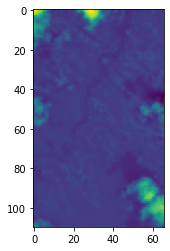

<AxesSubplot:>

In [17]:
# check that the first tile id covers the entire area
from rasterio.plot import show
show(hls_ds.sel(time=(hls_ds['tile_id']==hls_ds['tile_id'].values[0]))['BLUE'].isel(time=0).values)

In [18]:
# subset xarray to only the first tile
hls_ds = hls_ds.sel(time=(hls_ds['tile_id']==hls_ds['tile_id'].values[0]))

In [19]:
# chunk the dataset for efficient masking
hls_ds = hls_ds.chunk({'time': 1, 'y': 50, 'x': 50})
# mask the dataset using the native HLS mask
hls_mask = mask_hls(hls_ds['FMASK'], mask_types=['all'])
hls_ds = hls_ds.where(hls_mask == 0)

In [20]:
# convert time to datetime
hls_ds['time'] = pd.to_datetime(hls_ds.time)

# sort by time
hls_ds = hls_ds.sortby('time')

In [21]:
hls_ds

<xarray.Dataset>
Dimensions:         (time: 7, y: 110, x: 66)
Coordinates:
  * time            (time) datetime64[ns] 2019-06-16 2019-06-21 ... 2019-07-11
    id              (time) <U34 dask.array<chunksize=(7,), meta=np.ndarray>
  * x               (x) float64 4.89e+05 4.891e+05 ... 4.91e+05 4.91e+05
  * y               (y) float64 4.798e+06 4.798e+06 ... 4.795e+06 4.795e+06
    eo:cloud_cover  (time) int64 dask.array<chunksize=(7,), meta=np.ndarray>
    epsg            int64 32613
    tile_id         (time) <U6 'T13TDJ' 'T13TDJ' 'T13TDJ' ... 'T13TDJ' 'T13TDJ'
Data variables:
    BLUE            (time, y, x) float64 dask.array<chunksize=(7, 110, 66), meta=np.ndarray>
    GREEN           (time, y, x) float64 dask.array<chunksize=(7, 110, 66), meta=np.ndarray>
    RED             (time, y, x) float64 dask.array<chunksize=(7, 110, 66), meta=np.ndarray>
    NIR1            (time, y, x) float64 dask.array<chunksize=(7, 110, 66), meta=np.ndarray>
    SWIR1           (time, y, x) float64 dask.array<chunksize=(7, 110, 66), meta=np.ndarray>
    SWIR2           (time, y, x) float64 dask.array<chunksize=(7, 110, 66), meta=np.ndarray>
    FMASK           (time, y, x) float64 dask.array<chunksize=(7, 110, 66), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(489030, 4795200, 491010, 4798...
    crs:         epsg:32613
    transform:   | 30.00, 0.00, 489030.00|\n| 0.00,-30.00, 4798500.00|\n| 0.0...
    resolution:  30

In [22]:
# create an xarray mask from the ground data
pdog_info = gdf_pdog_2019.drop_duplicates(subset=['ID', 'Date'])[['ID', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
pdog_mask_shp = [(row.geometry, row.id+1) for _, row in pdog_info.iterrows()]
pdog_mask = shp2mask(shp=pdog_mask_shp, 
                     transform=hls_ds.rio.transform(), 
                     outshape=hls_ds['BLUE'].shape[1:], 
                     xr_object=hls_ds['BLUE'])
pdog_dict = {row.id+1: row.ID for _, row in pdog_info.iterrows()}
pdog_dict[0] = 'UNK'
plot_mask = np.array([pdog_dict[i] for i in pdog_mask.values.flatten()]).reshape(pdog_mask.shape)

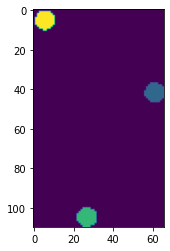

<AxesSubplot:>

In [23]:
# plot the plots
from rasterio.plot import show
show(pdog_mask.data)

In [24]:
# view the unique ID's
np.unique(plot_mask)

array(['UNK', 'lake creek-control-out', 'lake creek-fire-out',
       'lake creek-prairie dog-out'], dtype='<U26')

In [25]:
# assign the ID's to the xarray dataset
hls_ds = hls_ds.assign(Plot=(['y', 'x'], plot_mask)).chunk({'y': 50, 'x': 50})
hls_ds = hls_ds.set_coords('Plot')

In [26]:
# mask out areas outside ground plots
hls_ds = hls_ds.where(hls_ds['Plot'] != 'UNK')

<xarray.Dataset>
Dimensions:         (time: 7, y: 110, x: 66)
Coordinates:
  * time            (time) datetime64[ns] 2019-06-16 2019-06-21 ... 2019-07-11
    id              (time) <U34 dask.array<chunksize=(7,), meta=np.ndarray>
  * x               (x) float64 4.89e+05 4.891e+05 ... 4.91e+05 4.91e+05
  * y               (y) float64 4.798e+06 4.798e+06 ... 4.795e+06 4.795e+06
    eo:cloud_cover  (time) int64 dask.array<chunksize=(7,), meta=np.ndarray>
    epsg            int64 32613
    tile_id         (time) <U6 dask.array<chunksize=(7,), meta=np.ndarray>
    Plot            (y, x) <U26 dask.array<chunksize=(50, 50), meta=np.ndarray>
Data variables:
    BLUE            (time, y, x) float64 dask.array<chunksize=(7, 50, 50), meta=np.ndarray>
    GREEN           (time, y, x) float64 dask.array<chunksize=(7, 50, 50), meta=np.ndarray>
    RED             (time, y, x) float64 dask.array<chunksize=(7, 50, 50), meta=np.ndarray>
    NIR1            (time, y, x) float64 dask.array<chunksize=(7, 50, 50), meta=np.ndarray>
    SWIR1           (time, y, x) float64 dask.array<chunksize=(7, 50, 50), meta=np.ndarray>
    SWIR2           (time, y, x) float64 dask.array<chunksize=(7, 50, 50), meta=np.ndarray>
    FMASK           (time, y, x) float64 dask.array<chunksize=(7, 50, 50), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(489030, 4795200, 491010, 4798...
    crs:         epsg:32613
    transform:   | 30.00, 0.00, 489030.00|\n| 0.00,-30.00, 4798500.00|\n| 0.0...
    resolution:  30

In [27]:
# run the ndvi function to calculate NDVI from Red and NIR bands and save as a new variable
hls_ds['NDVI'] = ndvi_func(hls_ds)

In [28]:
hls_ds

<xarray.Dataset>
Dimensions:         (time: 7, y: 110, x: 66)
Coordinates:
  * time            (time) datetime64[ns] 2019-06-16 2019-06-21 ... 2019-07-11
    id              (time) <U34 dask.array<chunksize=(7,), meta=np.ndarray>
  * x               (x) float64 4.89e+05 4.891e+05 ... 4.91e+05 4.91e+05
  * y               (y) float64 4.798e+06 4.798e+06 ... 4.795e+06 4.795e+06
    eo:cloud_cover  (time) int64 dask.array<chunksize=(7,), meta=np.ndarray>
    epsg            int64 32613
    tile_id         (time) <U6 dask.array<chunksize=(7,), meta=np.ndarray>
    Plot            (y, x) <U26 dask.array<chunksize=(50, 50), meta=np.ndarray>
Data variables:
    BLUE            (time, y, x) float64 dask.array<chunksize=(7, 50, 50), meta=np.ndarray>
    GREEN           (time, y, x) float64 dask.array<chunksize=(7, 50, 50), meta=np.ndarray>
    RED             (time, y, x) float64 dask.array<chunksize=(7, 50, 50), meta=np.ndarray>
    NIR1            (time, y, x) float64 dask.array<chunksize=(7, 50, 50), meta=np.ndarray>
    SWIR1           (time, y, x) float64 dask.array<chunksize=(7, 50, 50), meta=np.ndarray>
    SWIR2           (time, y, x) float64 dask.array<chunksize=(7, 50, 50), meta=np.ndarray>
    FMASK           (time, y, x) float64 dask.array<chunksize=(7, 50, 50), meta=np.ndarray>
    NDVI            (time, y, x) float64 dask.array<chunksize=(7, 50, 50), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(489030, 4795200, 491010, 4798...
    crs:         epsg:32613
    transform:   | 30.00, 0.00, 489030.00|\n| 0.00,-30.00, 4798500.00|\n| 0.0...
    resolution:  30

In [31]:
# extract the means for each plot and convert to pandas dataframe
df_out = hls_ds['NDVI'].groupby('Plot').mean().to_dataframe().reset_index()
# remove the means for areas outside the plot (we already masked them, so all NaN)
df_out = df_out[df_out['Plot'] != 'UNK']
# preview
df_out

,time,Plot,id,eo:cloud_cover,epsg,tile_id,NDVI
1,2019-06-16,lake creek-control-out,HLS.S30.T13TDJ.2019167T174919.v2.0,50,32613,T13TDJ,NaN
2,2019-06-16,lake creek-fire-out,HLS.S30.T13TDJ.2019167T174919.v2.0,50,32613,T13TDJ,0.521926
3,2019-06-16,lake creek-prairie dog-out,HLS.S30.T13TDJ.2019167T174919.v2.0,50,32613,T13TDJ,NaN
5,2019-06-21,lake creek-control-out,HLS.S30.T13TDJ.2019172T174911.v2.0,84,32613,T13TDJ,NaN
6,2019-06-21,lake creek-fire-out,HLS.S30.T13TDJ.2019172T174911.v2.0,84,32613,T13TDJ,NaN
7,2019-06-21,lake creek-prairie dog-out,HLS.S30.T13TDJ.2019172T174911.v2.0,84,32613,T13TDJ,NaN
9,2019-06-26,lake creek-control-out,HLS.S30.T13TDJ.2019177T174919.v2.0,25,32613,T13TDJ,NaN
10,2019-06-26,lake creek-fire-out,HLS.S30.T13TDJ.2019177T174919.v2.0,25,32613,T13TDJ,NaN
11,2019-06-26,lake creek-prairie dog-out,HLS.S30.T13TDJ.2019177T174919.v2.0,25,32613,T13TDJ,0.507040
13,2019-06-30,lake creek-control-out,HLS.L30.T13TDJ.2019181T174211.v2.0,97,32613,T13TDJ,NaN


#### This was great, we extracted the actual mean NDVI values for each plot. But we can see that we don't actually have observations for most plots on 7-01-2019 when ground data were collected. We could use the closet observation, or we could use interpolation (see below).

### Let's re-do this with a longer time window and smooth

In [34]:
# get the data range for the fetch as a dictionary
start_date = gdf_plot.iloc[0].Date - timedelta(days=45)
end_date = gdf_plot.iloc[0].Date + timedelta(days=45)
data_dict = {'date_range': [str(start_date), 
                            str(end_date)]}

# fetch the data for the entire project PDOG, but for the date range around the single plot
hls_ds = fetch.get_hls(hls_data=data_dict,
                       bbox=bbox_data, 
                       stack_chunks=(400, 400),
                       proj_epsg=gdf_aoi.crs.to_epsg(),
                       lim=1000).drop_vars(['SZA', 'SAA', 'VZA', 'VAA']).chunk({'time': -1})

# create a tile ID coordinate
hls_ds = hls_ds.assign_coords(tile_id = ('time', [x.split('.')[2] for x in hls_ds['id'].values]))

# subset xarray to only the first tile
hls_ds = hls_ds.sel(time=(hls_ds['tile_id']==hls_ds['tile_id'].values[0]))

# chunk the dataset for efficient masking
hls_ds = hls_ds.chunk({'time': 1, 'y': 50, 'x': 50})
# mask the dataset using the native HLS mask
hls_mask = mask_hls(hls_ds['FMASK'], mask_types=['all'])
hls_ds = hls_ds.where(hls_mask == 0)

# convert time to datetime
hls_ds['time'] = pd.to_datetime(hls_ds.time)

# sort by time
hls_ds = hls_ds.sortby('time')

# assign the ID's to the xarray dataset
hls_ds = hls_ds.assign(Plot=(['y', 'x'], plot_mask)).chunk({'y': 50, 'x': 50})
hls_ds = hls_ds.set_coords('Plot')

# mask out areas outside ground plots
hls_ds = hls_ds.where(hls_ds['Plot'] != 'UNK')

# preview
hls_ds

<xarray.Dataset>
Dimensions:         (time: 23, y: 110, x: 66)
Coordinates:
  * time            (time) datetime64[ns] 2019-05-17 2019-05-27 ... 2019-08-10
    id              (time) <U34 dask.array<chunksize=(1,), meta=np.ndarray>
  * x               (x) float64 4.89e+05 4.891e+05 ... 4.91e+05 4.91e+05
  * y               (y) float64 4.798e+06 4.798e+06 ... 4.795e+06 4.795e+06
    eo:cloud_cover  (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    epsg            int64 32613
    tile_id         (time) <U6 dask.array<chunksize=(1,), meta=np.ndarray>
    Plot            (y, x) <U26 dask.array<chunksize=(50, 50), meta=np.ndarray>
Data variables:
    BLUE            (time, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    GREEN           (time, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    RED             (time, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    NIR1            (time, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    SWIR1           (time, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    SWIR2           (time, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    FMASK           (time, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(489030, 4795200, 491010, 4798...
    crs:         epsg:32613
    transform:   | 30.00, 0.00, 489030.00|\n| 0.00,-30.00, 4798500.00|\n| 0.0...
    resolution:  30

In [35]:
# run the ndvi function to calculate NDVI from Red and NIR bands and save as a new variable
hls_ds['NDVI'] = ndvi_func(hls_ds)

In [38]:
# rechunk the data for smoothing
hls_ds = hls_ds.chunk({'time': -1, 'y': 50, 'x': 50})

In [50]:
# smooth the NDVI time series in two steps, first despike, then Savitzy-Golay 
from src.hls_funcs.smooth import smooth_xr, despike_ts_xr
ndvi_da = despike_ts_xr(hls_ds['NDVI'],
                        dat_thresh=0.07, 
                        days_thresh=31,
                        mask_outliers=False,
                        iters=2,
                        dims=['time'])
ndvi_da = smooth_xr(ndvi_da,
                    dims=['time'], 
                    kwargs={'double': True, 'limit': 45, 'window1_min': 5, 'window2': 15})

In [51]:
# extract the means for each plot and convert to pandas dataframe
df_out_smooth =ndvi_da.groupby('Plot').mean().to_dataframe().reset_index()
# remove the means for areas outside the plot (we already masked them, so all NaN)
df_out_smooth = df_out_smooth[df_out_smooth['Plot'] != 'UNK']

In [52]:
# we now have a daily estimate of NDVI for each plot
df_out_smooth

,time,Plot,id,eo:cloud_cover,epsg,tile_id,NDVI
1,2019-05-17,lake creek-control-out,HLS.S30.T13TDJ.2019137T174919.v2.0,94,32613,T13TDJ,0.401731
2,2019-05-17,lake creek-fire-out,HLS.S30.T13TDJ.2019137T174919.v2.0,94,32613,T13TDJ,0.466996
3,2019-05-17,lake creek-prairie dog-out,HLS.S30.T13TDJ.2019137T174919.v2.0,94,32613,T13TDJ,0.440225
5,2019-05-27,lake creek-control-out,HLS.S30.T13TDJ.2019147T174919.v2.0,99,32613,T13TDJ,0.402831
6,2019-05-27,lake creek-fire-out,HLS.S30.T13TDJ.2019147T174919.v2.0,99,32613,T13TDJ,0.474414
...,...,...,...,...,...,...,...
86,2019-08-08,lake creek-fire-out,HLS.L30.T13TDJ.2019220T174833.v2.0,7,32613,T13TDJ,0.346796
87,2019-08-08,lake creek-prairie dog-out,HLS.L30.T13TDJ.2019220T174833.v2.0,7,32613,T13TDJ,0.337836
89,2019-08-10,lake creek-control-out,HLS.S30.T13TDJ.2019222T174911.v2.0,8,32613,T13TDJ,0.315678
90,2019-08-10,lake creek-fire-out,HLS.S30.T13TDJ.2019222T174911.v2.0,8,32613,T13TDJ,0.332221
